### <Center> Лабораторна робота №10. <br> Робота з незбалансованими вибірками

## Коротка постановка проблеми

У задачах класифікації баланс класів часто порушується, і зазвичай саме менший клас є цільовим.

Фрод, відмови техніки, позитивні медичні діагнози, небажана видача в пошуковику, відтік - лише частина прикладів таких завдань.

Чому звичайні алгоритми (без шаманства) не дуже добре працюють?

Якщо в загальних рисах, то справа в тому, що всередині багатьох алгоритмів зашита будь-яка оптимізація [loss] (https://en.wikipedia.org/wiki/Loss_function) -функції, часто вже не враховує баланс класів у вибірці. Саме тому модель прагне передбачити якомога ** більше ** об'єктів більшого класу, ігноруючи менший клас, але знижуючи загальний error-rate.

У цій лабораторній роботі ми розглянемо деякі методи, які дозволяють боротися з проблемою нерівних класів.

Як модельний датасет використаємо дані про раздачі в покері (hand), де ознаками є карти (масть -- Suit, ранг -- C), а target -- Poker Hand, тобто різноманітні комбінації наявних карт. Датасет можна скачати [тут](https://archive.ics.uci.edu/ml/datasets/Poker+Hand)

Коротний опис ознак (features) датасету:

```
1) S1 "Suit of card #1" 
Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs} 

2) C1 "Rank of card #1" 
Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King
```

Короткий опис цільової мітки (target) для [датасету](https://archive.ics.uci.edu/ml/datasets/Poker+Hand):

```
0: Nothing in hand; not a recognized poker hand
1: One pair; one pair of equal ranks within five cards
2: Two pairs; two pairs of equal ranks within five cards
3: Three of a kind; three equal ranks within five cards
4: Straight; five cards, sequentially ranked with no gaps
5: Flush; five cards with the same suit
6: Full house; pair + different rank three of a kind
7: Four of a kind; four equal ranks within five cards
8: Straight flush; straight + flush
9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush 
```

Чим більша цифра, тим рідше клас і тим виграшніша позиція.

Для прикладів нам знадобиться .py [скрипт](https://github.com/silicon-valley-data-science/learning-from-imbalanced-classes/blob/master/blagging.py) blagging.py, який можно просто покласти поруч рядом с ноутбуком, а также библиотека [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/index.html):

`pip install -U imbalanced-learn`

In [1]:
!pip install -U imbalanced-learn

In [5]:
# Завантаження бібліотек

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import neighbors
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

## Внутрішні параметри алгоритмів для врахування незбалансованості класів


Завантажимо дані і подивимося на них:

In [8]:
def load_and_prepare_data():
    
    # Завантажимо дані і подивимося на них

    df = pd.read_csv('data/poker-hand-training-true.data', 
                     names=['Suit1', 'C1', 'Suit2', 'C2', 'Suit3', 
                            'C3', 'Suit4', 'C4', 'Suit5', 'C5', 'CLASS'])
    
    # кодування порядкових (ordinal) ознак -- окрема тема, тут обійдемося one-hot

    ordinal_columns = [col for col in df.columns if 'Suit' in col]

    ohe = OneHotEncoder(sparse_output=False)

    encoded_ordinal = ohe.fit_transform(df[ordinal_columns])

    # видаляємо оригінальні колонки
    df.drop(ordinal_columns, axis=1, inplace=True)
    
    tmp = pd.DataFrame(encoded_ordinal, columns=['S ' + str(i) for i in range(encoded_ordinal.shape[1])])
    df = pd.concat([df, tmp], axis=1)
    
    return df

In [9]:
df = load_and_prepare_data()

In [4]:
df.head(10)

,C1,C2,C3,C4,C5,CLASS,S 0,S 1,S 2,S 3,...,S 10,S 11,S 12,S 13,S 14,S 15,S 16,S 17,S 18,S 19
0,10,11,13,12,1,9,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,11,13,10,12,1,9,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12,11,13,10,1,9,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,10,11,1,13,12,9,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,13,12,11,10,9,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,2,4,5,3,6,8,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,9,12,10,11,13,8,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1,2,3,4,5,8,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,5,6,9,7,8,8,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,1,4,2,3,5,8,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Поглянемо на розподіл класів у вибірці, щоб оцінити незбалансованість даних.

In [10]:
# Розподіл класів у вибірці

print("Initial class percentages: \n")
df.CLASS.value_counts()

Initial class percentages: 



CLASS
0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        5
Name: count, dtype: int64

In [11]:
X = df.drop('CLASS', axis=1).values
y = df.CLASS

Подивимося на якість алгоритмів as is, попередньо разбивши дані на train і test.

Під час перегляду метрик рекомендую особливо звертати увагу на `recall` класів чи на F1-міру.

In [12]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

In [13]:
from sklearn.metrics import classification_report

In [14]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.75      0.65      4997
           1       0.51      0.42      0.46      4240
           2       0.00      0.00      0.00       482
           3       0.00      0.00      0.00       205
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.55     10004
   macro avg       0.11      0.12      0.11     10004
weighted avg       0.50      0.55      0.52     10004



c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Як ми бачимо, найбільш рідкісні класи RandomForest з настройками за замовчуванням не знайшов і викидує варнінги про відсутність предиктів по ним.

Уявімо на секунду, що нас цікавлять класи з 6 по 9 включно, оскільки вони рідкісні і різко підвищують ймовірність перемоги. Подивимося, чи можливо підібрати ваги таким чином, щоб знайти ці класи.

В деяких алгоритмах існує можливість проставити `class_weight`, наприклад, для логістичної регресії і випадкового лісу і таким чином скоректувати штраф за хибно прогнозований об'єкт. Альтернативою ручному підбору є `'balanced'` опція, що проставляє ваги у відповідності з розподілом в навчальній вибірці.

In [15]:
searching_for_classes = ['balanced', 
                         {6:2, 7:2, 8:2, 9:2},
                         {6:10, 7:10, 8:10, 9:10}
                        ]

In [16]:
for option in searching_for_classes:
    
    clf = RandomForestClassifier(class_weight=option, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)

    print(classification_report(y_test, clf.predict(X_test)))

c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

           0       0.57      0.76      0.65      4997
           1       0.50      0.39      0.44      4240
           2       0.00      0.00      0.00       482
           3       0.00      0.00      0.00       205
           4       0.00      0.00      0.00        37
           5       1.00      0.05      0.09        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.54     10004
   macro avg       0.21      0.12      0.12     10004
weighted avg       0.50      0.54      0.51     10004



c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

           0       0.57      0.75      0.65      4997
           1       0.50      0.41      0.45      4240
           2       0.00      0.00      0.00       482
           3       1.00      0.00      0.01       205
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.55     10004
   macro avg       0.21      0.12      0.11     10004
weighted avg       0.52      0.55      0.52     10004

              precision    recall  f1-score   support

           0       0.57      0.77      0.66      4997
           1       0.51      0.40      0.45      4240
           2       0.00      0.00      0.00       482
           3       0.00 

c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Тепер спробуємо використати ExtraTreesClassifier

In [17]:
for option in searching_for_classes:
    
    clf = ExtraTreesClassifier(class_weight=option, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)

    print('weights: ' + str(option) + '\n' + classification_report(y_test, clf.predict(X_test)) + '\n' )

c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

weights: balanced
              precision    recall  f1-score   support

           0       0.52      0.64      0.58      4997
           1       0.45      0.40      0.42      4240
           2       0.10      0.01      0.02       482
           3       0.06      0.00      0.01       205
           4       0.00      0.00      0.00        37
           5       0.78      0.64      0.70        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.49     10004
   macro avg       0.19      0.17      0.17     10004
weighted avg       0.46      0.49      0.47     10004




c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

weights: {6: 2, 7: 2, 8: 2, 9: 2}
              precision    recall  f1-score   support

           0       0.52      0.63      0.57      4997
           1       0.44      0.41      0.42      4240
           2       0.08      0.01      0.02       482
           3       0.00      0.00      0.00       205
           4       0.00      0.00      0.00        37
           5       0.83      0.86      0.84        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.49     10004
   macro avg       0.19      0.19      0.19     10004
weighted avg       0.45      0.49      0.47     10004


weights: {6: 10, 7: 10, 8: 10, 9: 10}
              precision    recall  f1-score   support

           0       0.52      0.63      0.57      4997
           1       0.44      0.41      0.43      4240
     

c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Бачимо, що в першому випадку (з "'balanced'") ми тепер знаходимо 5-ий клас. Проте, це не совсім те, чого ми хотіли. Поглянемо на ймовірності, що проставлені класифікатором для кожного з класів.

In [18]:
predicted_probs = clf.predict_proba(X_test)

In [19]:
pd.DataFrame(predicted_probs, 
             columns=['prob_' + str(i) for i in range(0,10)]) \
             [["prob_6", "prob_7", "prob_8", "prob_9"]].describe()

,prob_6,prob_7,prob_8,prob_9
count,10004.000000,10004.000000,10004.000000,10004.000000
mean,0.001968,0.000233,0.000209,0.000270
std,0.013719,0.003984,0.003464,0.006156
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.490000,0.300000,0.210000,0.430000


Можна було б скористатися стандартним прийомом і викрутити поріг на ймовірності, тобто назначати клас за меншим, ніж дефолтний 0.5 поріг, спіймавши частину екземплярів класу. Однак ми бачимо, що в даному випадку такий підхід не має сенсу -- ймовірності досить малі і таких прикладів зовсім небагато.

Ми ще повернемося до проблеми визначення настільки малих класів.

### Blagging Classifier

Тепер посмотрим на работу Blagging Classifier'а, который из коробки умеет балансировать классы.

Чудове інтуїтивне уявлення про роботу цього класифікатора дає [цей](https://github.com/yanshanjing/learning-from-imbalanced-classes/blob/master/Gaussians.ipynb) ноутбук, а саму статтю з підходом можно знайти [тут](https://pdfs.semanticscholar.org/a8ef/5a810099178b70d1490a4e6fc4426b642cde.pdf).

Ну і програмний код [тут](https://github.com/yanshanjing/learning-from-imbalanced-classes/blob/master/blagging.py), звичайно.


В загальних рисах підхід наступний:

* Bootstrap з датасету
* Балансування шляхом зменшення розміру великого класу (downsampling)
* Навчання Decision Tree на кожній з вибірок
* Majority vote на наборі дерев

<img src="https://habrastorage.org/web/29a/31c/af6/29a31caf67f8449dace109394b8b7e6a.png"/>

Картинка [звідси](https://svds.com/learning-imbalanced-classes/)

Нажаль цей класифікатор працює тільки для бінарної класифікації, тому ми зведемо задачу до такого вигляду. Нехай у нас є рідкісні, але виграшні класи і декілька класів з найбільшою кількістю прикладів, що не є виграшними.

In [20]:
df = load_and_prepare_data()

In [21]:
# ще раз подивимося на розподіл класів

df.CLASS.value_counts()

CLASS
0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        5
Name: count, dtype: int64

In [22]:
def make_binary(original_data, pos_classes):
    return np.array([(1 if val in pos_classes else 0)
                     for val in original_data ])

In [23]:
binary_y = make_binary(df.CLASS, set((4, 5, 6, 7, 8, 9)))
print("After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 \n")

np.unique(binary_y, return_counts=True)

After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 



(array([0, 1]), array([24811,   199]))

Проблема залишилася досить незбалансованою, давайте перевіримо як поведуть себе алгоритми sklearn і порівняємо з BlaggingClassifier'ом.

In [24]:
X = df.drop('CLASS', axis=1).values
y = binary_y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

RandomForest:

In [25]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9924
           1       0.00      0.00      0.00        80

    accuracy                           0.99     10004
   macro avg       0.50      0.50      0.50     10004
weighted avg       0.98      0.99      0.99     10004



c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

GradientBoosting:

In [26]:
clf = GradientBoostingClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9924
           1       1.00      0.01      0.02        80

    accuracy                           0.99     10004
   macro avg       1.00      0.51      0.51     10004
weighted avg       0.99      0.99      0.99     10004



In [31]:
!pip install -U scikit-learn==0.21.3

     ---------------------------------------- 0.0/12.2 MB ? eta -:--:--
     ------------ --------------------------- 3.9/12.2 MB 33.4 MB/s eta 0:00:01
     --------------------------------------- 12.2/12.2 MB 47.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      <string>:12: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      Partial import of sklearn during the build process.
      Traceback (most recent call last):
        File "<string>", line 187, in get_numpy_status
      ModuleNotFoundError: No module named 'numpy'
      Traceback (most recent call last):
        File "C:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "C:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^

Досі ніяких значних покращень, навіть після merge класів.

Як ми бачимо, `BlaggingClassifier` чудово показав себе, видав пристойну повноту для такої задачі.

Для мене був сюрпризом результат ExtraTreesClassifier:

In [33]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9924
           1       0.88      0.26      0.40        80

    accuracy                           0.99     10004
   macro avg       0.93      0.63      0.70     10004
weighted avg       0.99      0.99      0.99     10004



Можна подумати (але ми не будемо) про те, як об'єднати прогнози ExtraTreesClassifier і BlaggingClassifier для кращого результату.

Давайте тепер подивимося на AUC-ROC для кожного з класифікаторів.
Можна відмітити, що варто побудувати AUC-ROC на крос-валідації по фолдам, оскільки деякі з об'єктів можуть бути нетиповими для класу і це буде помітно під час розбиття, а також оцінка буде менш зміщеною, але ми обмежимося поділом на train-test для демонстрації методів.

In [35]:
clfs = [
        ['RandomForestClassifier', RandomForestClassifier(random_state=RANDOM_STATE)],
        ['GradientBoostingClassifier', GradientBoostingClassifier(random_state=RANDOM_STATE)],
        ['ExtraTreesClassifier', ExtraTreesClassifier(random_state=RANDOM_STATE)]
       ]

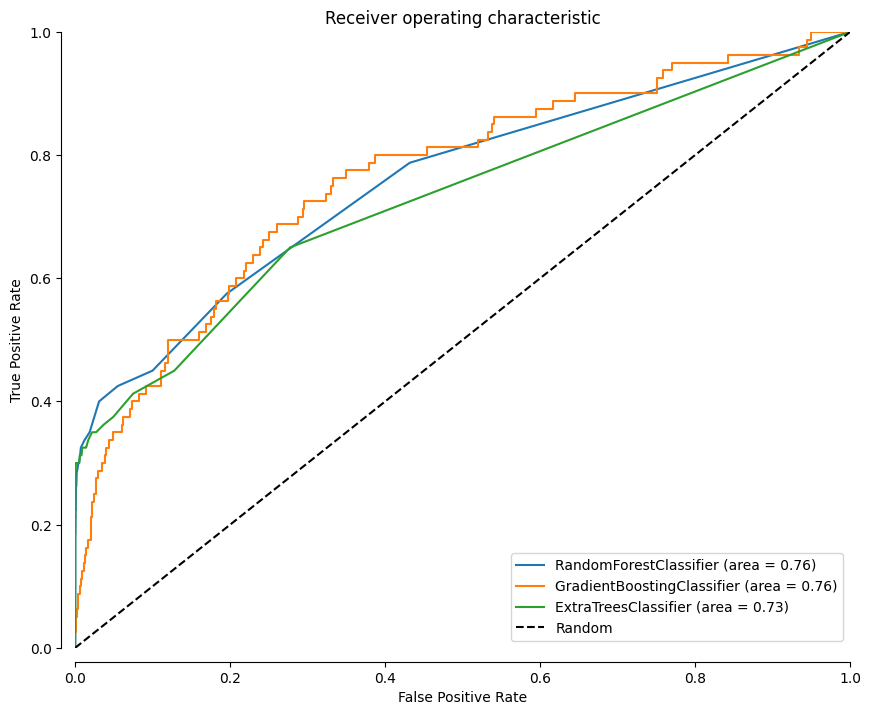

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in clfs:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (area = %0.2f)'.format(name) % roc_auc)
    
plt.plot([0, 1], [0, 1], linestyle='--', color='k',
         label='Random')    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.legend(loc="lower right")

plt.show()    

Видно, що за рахунок "завалювання прогнозів класифікатора в більший клас, градієнтний бустінг виграє в BlaggingClassifier'а.

Але давайте поглянемо на AUC-PR і повноту по рідкісному класу і все встане на свої місця.

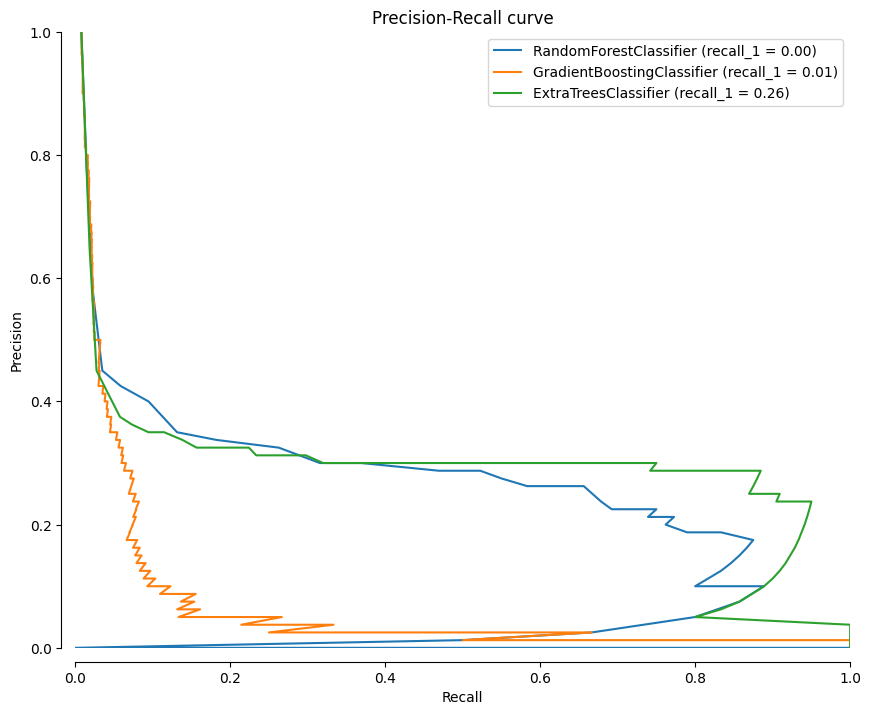

In [37]:
from sklearn.metrics import recall_score

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in clfs:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    recall_1 = recall_score(y_test, clf.predict(X_test))
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (recall_1 = %0.2f)'.format(name) % recall_1)
    
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

plt.legend(loc="upper right")

plt.show()    

Тут ми бачимо, що найбільша `recall` меншого класу саме в Blagging Classifier'а.

## Библиотека imbalanced-learn

[Бібліотека](http://contrib.scikit-learn.org/imbalanced-learn/install.html) imbalanced-learn дозволяє використовувати різноманітні техніки семплювання (як over, так і under, а також їх комбінації). Позаду деяких технік стоять нетривіальні підходи, що не входять в даний туторіал, але я залишу посилання.

Бібліотека включає :

* Under-sampling methods. Все просто, семплюємо з більшого класу для вирівнювання вибірки по меншому класу. Можливі два варіанти: 
 - генерація нових прикладів з більшого класу на основі [центроїд](http://contrib.scikit-learn.org/imbalanced-  learn/generated/imblearn.under_sampling.ClusterCentroids.html) кластерів;
 - [вибірка](http://contrib.scikit-learn.org/imbalanced-learn/api.html#module-imblearn.under_sampling.prototype_selection) прикладів з більшого класу різними способами (їх досить багато)


* Over-sampling methods. Тут теж все просто -- ми додаємо в датасет приклади меншого класу, просто [копіюванням](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.over_sampling.RandomOverSampler.html) або використовуючи більш хитрі техніки як, наприклад, [SMOTE](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html), який дозволяє генерувати синтетичні приклади на основі близькості декількох сусідів в ознаковому просторі, створюючи (с включенням випадковості) новий вектор ознак для нового прикладу. [Тут](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/node6.html#SECTION00042000000000000000) детальніше.

Давайте подивимося як поведуть себе ці методи на оригінальному датасеті за наявності всіх класів.

In [39]:
df = load_and_prepare_data()

X = df.drop('CLASS', axis=1).values
y = df.CLASS

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

In [40]:
df.CLASS.value_counts()

CLASS
0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        5
Name: count, dtype: int64

Почнемо з простого -- звичайний undersampling:

In [41]:
clf = ExtraTreesClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.52      0.63      0.57      4997
           1       0.44      0.41      0.43      4240
           2       0.11      0.01      0.02       482
           3       0.11      0.00      0.01       205
           4       0.00      0.00      0.00        37
           5       0.83      0.86      0.84        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.49     10004
   macro avg       0.20      0.19      0.19     10004
weighted avg       0.46      0.49      0.47     10004



c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dmitry\Documents\Repos\Data_Science_Intro\.venv312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Уже неплохо (5,6 и 7 классы), но мы сильно просели по большим классам.

Попробуем [CondensedNearestNeighbour](http://machinelearning.org/proceedings/icml2005/papers/004_Fast_Angiulli.pdf):

In [46]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose_hiive as mlrose

In [47]:
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler
from imblearn.pipeline import make_pipeline

pipe = make_pipeline(CondensedNearestNeighbour(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.51      0.21      0.29      4997
           1       0.43      0.44      0.44      4240
           2       0.06      0.24      0.09       482
           3       0.02      0.08      0.03       205
           4       0.00      0.00      0.00        37
           5       0.17      0.82      0.28        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.31     10004
   macro avg       0.12      0.18      0.11     10004
weighted avg       0.44      0.31      0.34     10004



Вже краще, ми знову бачимо великі класи!

Варто відмітити, що багато з методів, доступних в imbalanced-learn не працюють для мультикласової постановки задачі. Тому повернемося до бінарної постановки для демонстрації підходу over-sampling.

In [48]:
df = load_and_prepare_data()
binary_y = make_binary(df.CLASS, set((4, 5, 6, 7, 8, 9)))

print("After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 \n")

np.unique(binary_y, return_counts=True)
X = df.drop('CLASS', axis=1).values
y = binary_y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 



In [49]:
from imblearn.over_sampling import RandomOverSampler

pipe = make_pipeline(RandomOverSampler(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9924
           1       0.91      0.26      0.41        80

    accuracy                           0.99     10004
   macro avg       0.95      0.63      0.70     10004
weighted avg       0.99      0.99      0.99     10004



Навіть звичайний over-sampling справился непогано.

In [50]:
from imblearn.over_sampling import SMOTE

pipe = make_pipeline(SMOTE(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9924
           1       0.88      0.26      0.40        80

    accuracy                           0.99     10004
   macro avg       0.93      0.63      0.70     10004
weighted avg       0.99      0.99      0.99     10004



Варто відмітити, що imblearn має свою функцію оцінки якості моделі, що включає precision, recall, specificity (true negative rate), f1, геометричне середнє recall (sensitivity) і specificity, а також index balanced [accuracy](http://repositori.uji.es/xmlui/bitstream/handle/10234/23961/33068.pdf?sequence=1).

Останній розраховується наступним чином:

$$ IBA = (1 + Dominance)· Gmean^2 ,$$
    де
$$ Dominance = True Positive Rate - True Negative Rate $$

In [51]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, pipe.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.26      1.00      0.51      0.28      9924
          1       0.88      0.26      1.00      0.40      0.51      0.24        80

avg / total       0.99      0.99      0.27      0.99      0.51      0.28     10004



Наостанок побудуємо ROC-криві для деяких методів.

In [52]:
class DummySampler(object):

    def fit(self, X, y):
        return self

    def fit_sample(self, X, y):
        return X, y 
    
    def fit_resample(self, X, y):
        return X, y 

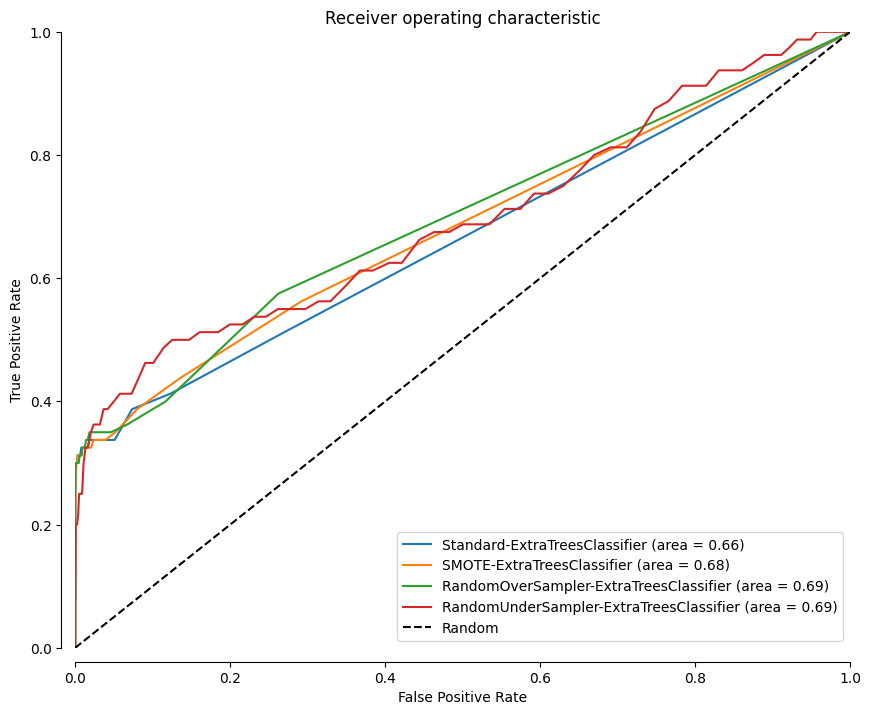

In [53]:
classifier = ['ExtraTreesClassifier', ExtraTreesClassifier()]

samplers = [
    ['Standard',           DummySampler()],
    ['SMOTE',              SMOTE(random_state=RANDOM_STATE)],
    ['RandomOverSampler',  RandomOverSampler(random_state=RANDOM_STATE)],
    ['RandomUnderSampler', RandomUnderSampler(random_state=RANDOM_STATE)]
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], classifier[1])]
    for sampler in samplers
]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in pipelines:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (area = %0.2f)'.format(name) % roc_auc)
    
plt.plot([0, 1], [0, 1], linestyle='--', color='k',
         label='Random')    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.legend(loc="lower right")

plt.show()    